In [1]:
%matplotlib inline
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import model_from_json
import matplotlib.pyplot as plt
import numpy as np
import os, random, sys
from data_preprocessing import create_data_generators
import json
from sklearn.metrics import confusion_matrix

In [2]:
RESULTS_FOLDER = "../saved_models/20190610_1512"
RESULTS_FOLDER = "../saved_models/20190612_1048"
HYPERPARAMS_FILE =  RESULTS_FOLDER+ '/hyperparams.json'

with open(HYPERPARAMS_FILE, "r") as read_file:
    data = json.load(read_file)

HYPERPARAMS = data['hyperparameters'][0]
BATCHSIZE = HYPERPARAMS['BATCHSIZE']

#20190612_1048
if (os.getcwd() == '/home/kalkami/translearn'):
    #lhcpgpu1
    TRAIN_DIR = '/data/IntelliGate/kalkami/DATASETS/carsStanford_all/train'
    TEST_DIR = '/data/IntelliGate/kalkami/DATASETS/carsStanford_all/test'
    TRAIN_DIR_TST = TRAIN_DIR
    TEST_DIR_TST = TEST_DIR
else:
    #local
    TRAIN_DIR = '/media/kamila/System/Users/Kama/Documents/DATASETS/carsStanford_s/train'
    TEST_DIR = '/media/kamila/System/Users/Kama/Documents/DATASETS/carsStanford_s/test'
    TRAIN_DIR_TST = '/media/kamila/System/Users/Kama/Documents/DATASETS/carsStanford_all/train'
    TEST_DIR_TST = '/media/kamila/System/Users/Kama/Documents/DATASETS/carsStanford_all/test'
    #TEST_DIR_TST = '/media/kamila/System/Users/Kama/Documents/DATASETS/CARS_GOOGLE_IMG/downloads'



In [12]:
def load_image(img_path, input_shape, show=False):
    img_org = image.load_img(img_path) 
    img = image.load_img(img_path, target_size=input_shape)
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_org)                           
        plt.axis('off')
        plt.show()

    return img_tensor

def decode_predictions(preds, class_names, top=5):
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [(class_names[i], pred[i]) for i in top_indices]
        result.sort(key=lambda x: x[1], reverse=True)
        results.append(result)
    return results

def predict(img_path, model, input_shape, class_names, correct_class):
    img_array = load_image(img_path, input_shape)
    preds = model.predict(img_array)
    predictions = decode_predictions(preds, class_names)
    top1_pred = predictions[0][0]
    print(predictions)
    img_org = image.load_img(img_path)
    fig, axs = plt.subplots(1,2)
    axs[0].set_title(correct_class)
    axs[0].imshow(img_org)
    axs[1].set_title(str(top1_pred))
    axs[1].imshow(img_array[0])
    plt.show()
    #pred_decoded = decode_predictions(pred)[0]
    ## Print the predictions.
    #for code, name, score in pred_decoded:
        #print("{0:>6.2%} : {1}".format(score, name))
        
def generate_data_generators(input_shape):
    generator_train, generator_test = create_data_generators(input_shape, BATCHSIZE, 
                                                                TRAIN_DIR, TEST_DIR, 
                                                                save_augumented=None, 
                                                                plot_imgs = False)
    return generator_train, generator_test
    
    
        
def load_model(results_folder):
    # load json and create model
    json_file = open(results_folder + '/model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(results_folder + "/weights.best.hdf5")
    input_shape = loaded_model.layers[0].output_shape[1:3]
    print("Loaded model from disk")
    return loaded_model, input_shape



def print_confusion_matrix(cls_pred, cls_test, class_names):
    '''Helper-function for printing confusion matrix'''
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.
    print("Confusion matrix:")
    # Print the confusion matrix as text.
    print(cm)    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))
        

def show_model_performance(loaded_model, generator_train, generator_test):
    steps_test = generator_test.n / BATCHSIZE
    steps_train = generator_test.n / BATCHSIZE
    cls_train = generator_train.classes
    cls_test = generator_test.classes
    class_names = list(generator_train.class_indices.keys())
    # Predict the classes for all images in the test-set
    y_pred = loaded_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    # plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred, cls_test, class_names)
    #result = loaded_model.evaluate_generator(generator_test, steps=steps_test)
    #result_train = loaded_model.evaluate_generator(generator_train, steps=steps_train)
    #print("Train-set classification accuracy: {0:.2%}".format(result_train[1]))
    #print("Test-set classification accuracy: {0:.2%}".format(result[1]))
        

def perform_pred(loaded_model, car_class, img_pth=None):
    test_dir = TEST_DIR_TST
    results_folder = RESULTS_FOLDER
    if img_pth is None: 
        # randomly select an image from defined class     
        test_dir_full = test_dir + '/' + car_class
        test_img = test_dir_full + '/' + random.choice(os.listdir(test_dir_full))
    else:
        test_img = img_pth
        
    
    input_shape = loaded_model.layers[0].output_shape[1:3]
    
    if os.path.exists(results_folder+'/class_names.txt'):
        class_names = []
        # open file and read the content in a list
        with open(results_folder+'/class_names.txt', 'r') as filehandle:  
            for line in filehandle:
                current_line = line[:-1]
                class_names.append(current_line)
    else:
        generator_train, generator_test = generate_data_generators(results_folder, input_shape)
        class_names = list(generator_train.class_indices.keys())
        print(class_names)
        with open(results_folder+'/class_names.txt', 'w') as filehandle:  
            for listitem in class_names:
                filehandle.write('%s\n' % listitem)
            
    predict(test_img, loaded_model, input_shape, class_names, car_class)

In [13]:
loaded_model, input_shape=load_model(RESULTS_FOLDER)
generator_train, generator_test = generate_data_generators(input_shape)


Loaded model from disk
Found 122 images belonging to 3 classes.
Found 121 images belonging to 3 classes.
Confusion matrix:
[[40  0  1]
 [ 4 30  4]
 [ 0  1 41]]
(0) Audi A5 Coupe 2012
(1) BMW X3 SUV 2012
(2) Dodge Caliber Wagon 2007


AttributeError: 'Model' object has no attribute 'total_loss'

In [ ]:
show_model_performance(loaded_model, generator_train, generator_test)

[[('BMW X3 SUV 2012', 0.56759638), ('Audi A5 Coupe 2012', 0.22424619), ('Dodge Caliber Wagon 2007', 0.20815748)]]


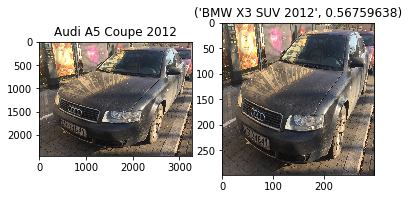

In [6]:
perform_pred(loaded_model, 'Audi A5 Coupe 2012', '/media/kamila/System/Users/Kama/Desktop/InteliGate/auta/dataset2/IMG_9787.JPG')